## Following code by Alberto Patania

In [41]:
import numpy as np 
import matplotlib.pyplot as plt
import xarray as xr
import netCDF4 as nc
#import cartopy.crs as ccrs
#import cartopy.feature as cfeature
import matplotlib.pylab as pylab
import pandas as pd
import scipy.stats as st
import seaborn as sns
import tensorflow as tf
import tensorflow.keras as keras
from scipy.optimize import curve_fit
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error as mse
from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer
from tensorflow import keras
from tensorflow.keras import layers

import seaborn as sns
from tensorflow.keras import layers
%matplotlib inline

In [42]:
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (13, 7),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

## 1.  *Nonlinear fitting.  
Choose parametersa,b,ωand compute the time seriesy(t) =a+bsin(ωt+φ) + 0.3ξ
whereξ∼ N(1,5) is a normally distributed noise for t ∈[−100,100].  
Now build 3models predicting the values of this time series:
    (a)  using curve fitting with scipy.optimize.curvefit() to the functiony(t) =A+Bsin(Ct+D)with parametersA,B,C, andD
    (b)  using any shallow learning model that you find interesting.
    (c)  using Deep learning network.Hint:to obtain good fit using neural networks use custom activation func-tionf(x) = sin(x), or a transformation layer (see next lab).
        Compare the performance of the models by calculating MSE.

In [43]:

def timeseries_data_generator(time=0,a=1.0,b=1.0,angular_frequency=np.pi,phi=0,numb_points=201):
    
    '''
    Description: Generates a time-series of data , add  noise generated by a normal distribution.
    
    ------------------------------------------------------------------------
    Variables:
    
    time(float) = array of time values from which to generate the output data
    a(float) = constant
    b(float) = constant
    angular_frequency(float) = angular frequency of the sine argument
    
    
    '''
    
    return a+b*np.sin(angular_frequency*time+phi)+0.3*np.random.normal(loc=1,scale=5, size=(numb_points))

def ffit(x,A,B,C,D):
    
    return A+B*np.sin(C*x+D)






# Generate the time series data

In [44]:
time_input = np.arange(-100,101,1)
time_series_output = timeseries_data_generator(time=time_input,a=0.75,b=4.5,angular_frequency=0.07,phi=1.6)

Text(0, 0.5, 'y(t)')

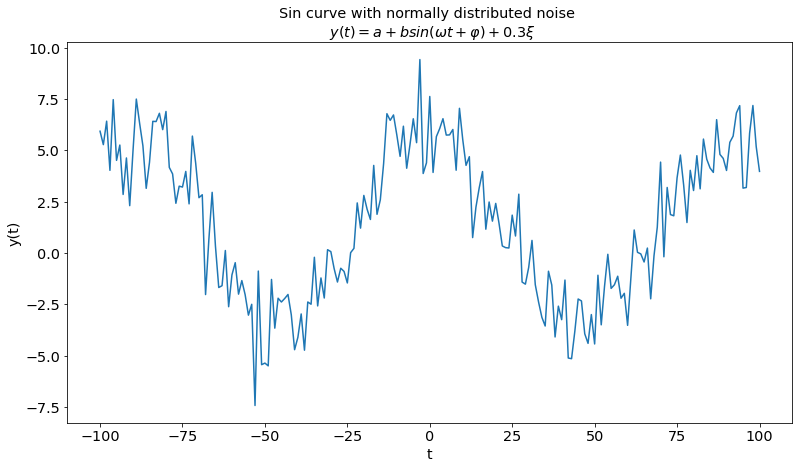

In [45]:
plt.plot(time_input,time_series_output)
plt.title("Sin curve with normally distributed noise \n $y(t) =a+bsin(ωt+φ) + 0.3ξ$")
plt.xlabel("t")
plt.ylabel("y(t)")

## Try scipy.curvefit to predict this sine curve

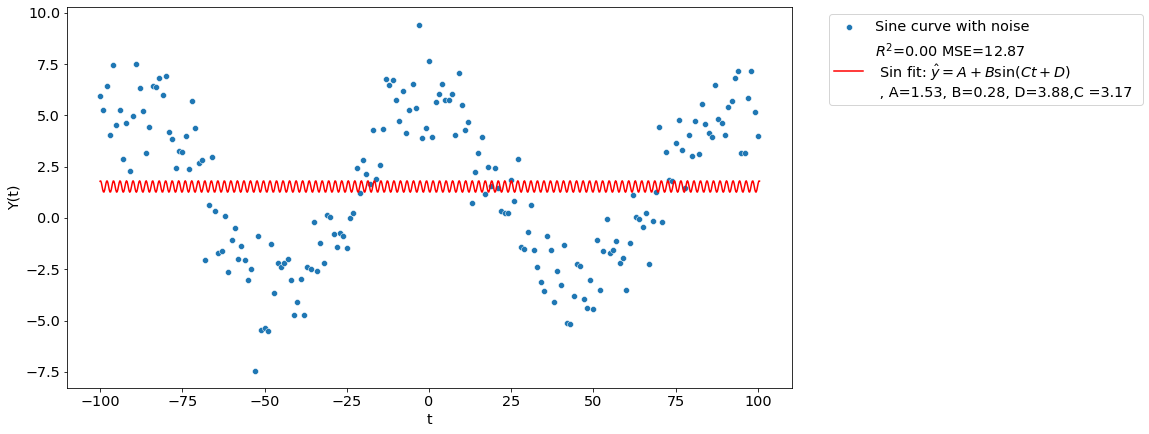

In [46]:

X = time_input

Y = time_series_output

#### scatter wind speed versus days in May #####

ax=sns.scatterplot(x=X,y=Y,label='Sine curve with noise')

##### define sine function to fit to data #####


(A,B,C,D),pcov=curve_fit(ffit,X,Y,p0=(1.0,1.0,np.pi,2.0))

# initial guesses 5,10,0,2pi/30

x=np.linspace(np.min(X),np.max(X)+0.5,1000)

y=ffit(x,A,B,C,D)

yp=ffit(X,A,B,C,D)

## calculate mean squared error ####

mse_res=mse(Y,yp)

### calculate R^2 ####

r2=r2_score(Y,yp)

plt.plot(x,y,'r-',label='$R^2$=%3.2f MSE=%3.2f \n Sin fit: $\hat{y} =A+B \sin(C t+D)$ \n , A=%3.2f, B=%3.2f, D=%3.2f,C =%3.2f ' %(r2,mse_res,A,B,D,C))

plt.xlabel('t')

plt.ylabel('Y(t)')

plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")

#plt.title('Sin fit: $\hat{y} =A+B \sin(C t+D)$ \n , A=%3.2f, B=%3.2f, D=%3.2f,C =%3.2f ' %(A,B,D,C))

# Try random forest approach to predict the sine time series.

In [47]:
y = time_series_output
X = time_input.reshape(-1,1)
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size = 0.25)
rf = RandomForestRegressor(n_estimators=20)
rf.fit(train_X, train_y)
Zp = rf.predict(test_X)
print("Training score:", rf.score(train_X,train_y))
print("Testing score:", rf.score(test_X, test_y))
print("MSE on test-data:",mse(Zp,test_y))


Training score: 0.968389978694984
Testing score: 0.7949002401380938
MSE on test-data: 2.614578422374035


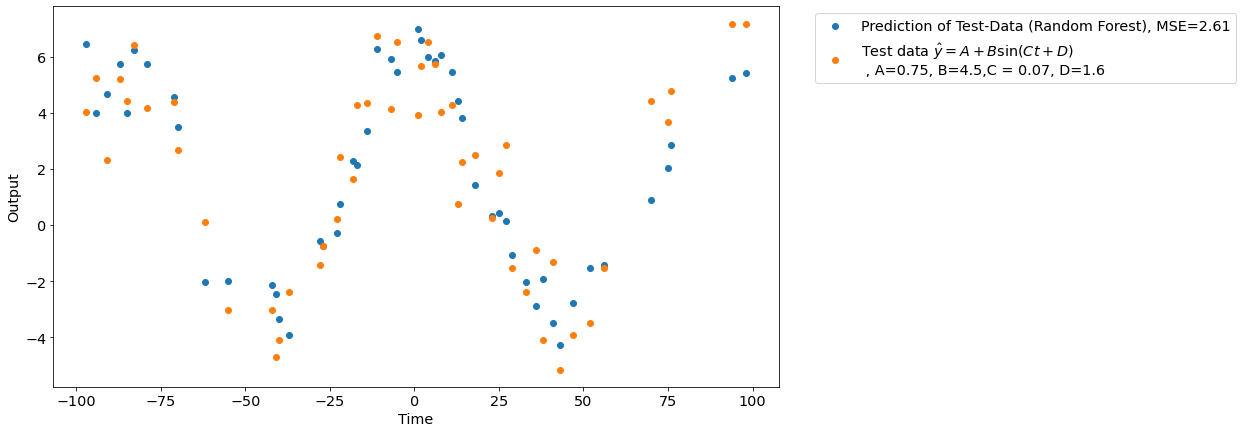

In [48]:

plt.scatter(test_X,Zp,label='Prediction of Test-Data (Random Forest), MSE=%3.2f' %mse(Zp,test_y))
plt.scatter(test_X,test_y,label='Test data $\hat{y} = A+B \sin(C t+D)$\n , A=0.75, B=4.5,C = 0.07, D=1.6')
#plt.title('$\hat{y} =A+B \sin(C t+D)$ \n , A=0.75, B=4.5,C = 0.07, D=1.6')
plt.xlabel('Time')
plt.ylabel('Output')
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")

# Cross-validation to check how RF performs on many runs

In [49]:
scores = cross_val_score(rf, X, y,    #cv sets the number of folds
                        scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)
print("RMSE Scores:", tree_rmse_scores)
print("Mean:", -scores.mean())
print("Standard deviation:", scores.std())

RMSE Scores: [2.05953214 2.46927498 2.1253621  2.50032643 2.37537025 1.56687144
 1.76338081 1.59701913 2.92086607 2.14824559]
Mean: 4.8011657500866285
Standard deviation: 1.7962843502774672


# Now try deep learning approach to predict sin(x) time series

## Define a custom activation function

In [50]:
def sin_act(x):
    return tf.math.sin(x)

# Build the model 

In [51]:
inp =  keras.layers.Input(shape=[1],dtype=tf.float32)
lsin= keras.layers.Dense(500, activation=sin_act,dtype=tf.float32) (inp)
lc=keras.layers.Concatenate()([inp,lsin])
out=keras.layers.Dense(1,  activation="linear") (lc)
model=keras.models.Model(inputs=[inp], outputs=[out])

In [52]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 500)          1000        input_3[0][0]                    
__________________________________________________________________________________________________
concatenate_2 (Concatenate)     (None, 501)          0           input_3[0][0]                    
                                                                 dense_4[0][0]                    
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 1)            502         concatenate_2[0][0]        

## Set a learning rate, number of epochs to train for, use Adam optimizer, mean_squarred error

In [53]:
epochs=50
lr = tf.keras.optimizers.schedules.PolynomialDecay(1e-3, epochs, 1e-4)
opt = tf.keras.optimizers.Adam(lr)
model.compile(loss="mse", optimizer=opt, metrics=["mae"])

## Set early stopping condition

In [54]:
es = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.001,patience=5, restore_best_weights=True)

##  Train the model

Train on 135 samples, validate on 15 samples
Epoch 1/50
135/135 [==============================] - 1s 7ms/sample - loss: 38.2708 - mae: 5.0942 - val_loss: 21.2443 - val_mae: 4.0977
Epoch 2/50
135/135 [==============================] - 0s 679us/sample - loss: 19.1980 - mae: 3.5954 - val_loss: 16.5675 - val_mae: 3.3676
Epoch 3/50
135/135 [==============================] - 0s 666us/sample - loss: 17.6855 - mae: 3.4084 - val_loss: 15.9709 - val_mae: 3.1517
Epoch 4/50
135/135 [==============================] - 0s 754us/sample - loss: 17.0882 - mae: 3.2978 - val_loss: 14.7368 - val_mae: 3.0819
Epoch 5/50
135/135 [==============================] - 0s 650us/sample - loss: 15.6017 - mae: 3.1727 - val_loss: 13.0313 - val_mae: 3.0767
Epoch 6/50
135/135 [==============================] - 0s 637us/sample - loss: 14.3101 - mae: 3.1094 - val_loss: 12.5518 - val_mae: 3.1259
Epoch 7/50
135/135 [==============================] - 0s 665us/sample - loss: 14.0326 - mae: 3.1212 - val_loss: 12.5488 - val_mae

<AxesSubplot:>

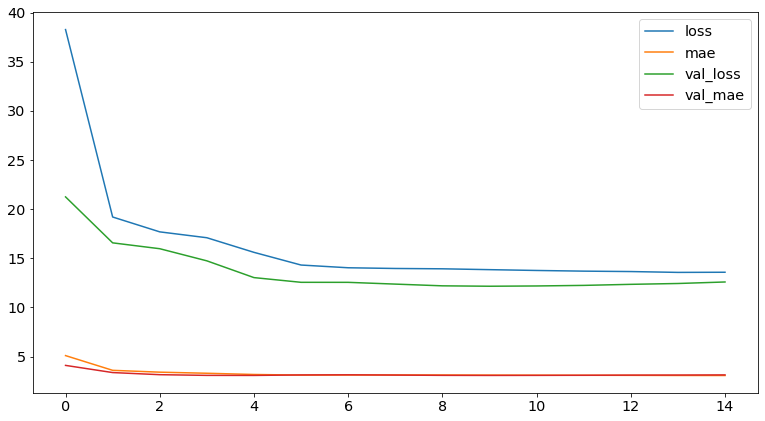

In [55]:
history = model.fit(tf.cast(train_X,dtype=tf.float32),tf.cast(train_y,dtype=tf.float32), epochs=epochs, validation_split=0.1,callbacks=[es])
pd.DataFrame(history.history).plot()

# Evaluate the model

In [56]:
#evaluating
print(model.evaluate(test_X,test_y, verbose= 0))


[15.261238079445034, 3.4151292]


## Make a prediction using the trained model

Deep learning R2: -0.197, MSE: 15.261 


Text(0.5, 1.0, 'Non-linear fitting with DNN')

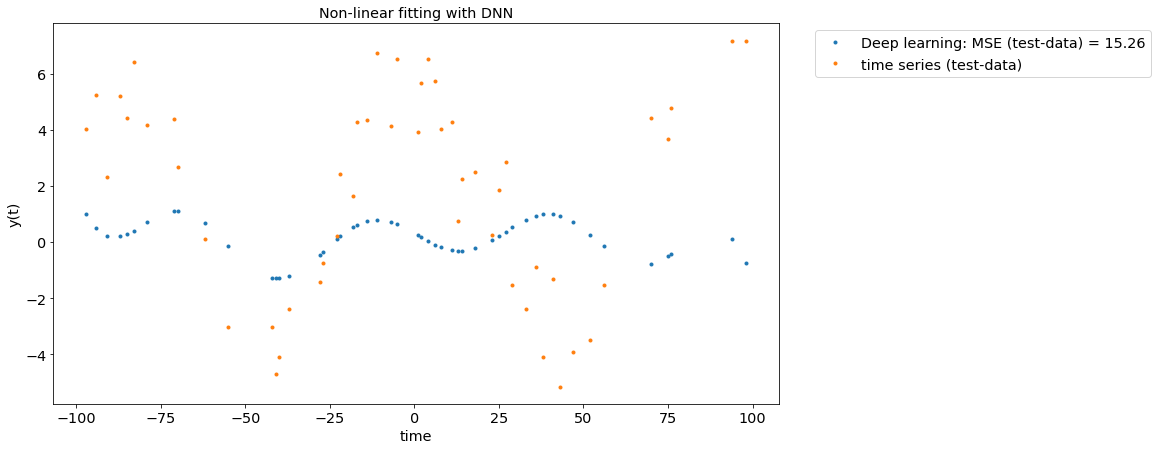

In [57]:
pred = model.predict(tf.cast(test_X,dtype=tf.float32))

print("Deep learning R2: %3.3f, MSE: %3.3f " %(r2_score(test_y, pred), mse(test_y, pred)))

fig = plt.figure()
plt.plot(test_X, pred, '.', label = "Deep learning: MSE (test-data) = %3.2f" %(mse(test_y,pred)))
plt.plot(test_X,test_y,'.', label = "time series (test-data)")
plt.xlabel("time")
plt.ylabel("y(t)")
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.title('Non-linear fitting with DNN')

## Prediction with DNN is not great MSE=21, probably need to use an autoregressive algorithm, such as  recurrent-neural network (RNN) , LSTM etc..

## Random forest has the best MSE on test data (MSE=3.13).

2.  *  Predict  future  Sea  Surface  Temperature  (SST1y)  or  (SST3m)  from  other  fieldsusing  El  Nino  datasetelnino-80-98.csv.   The  dataset  contains  information  for1980-1998 from nearly 70 moored buoys spanning the equatorial Pacific, measuringoceanographic and surface meteorological variables.  SST1y and SST3m fields con-tain Sea surface temperature at the same location after 1 year (366 days) and 90days, respectively.  You can choose which of the future fields (SST1y or SST3m) topredict.Compute MSE and correlation of your predictions with observed SST values.  Makea scatter plot of predicted v observed values.

In [58]:
df = pd.read_csv("elnino-80-98.csv")

In [59]:
df
#print(df.columns)
#print(df.describe().T)

,Unnamed: 0,Observation,Year,Month,Day,Date,Latitude,Longitude,Zonal_Winds,Meridional_Winds,Humidity,Air_Temp,SST,Nino34,SST3m,SST1y
0,0,1,80,3,7,800307,-0.02,-109.46,-6.8,0.7,NaN,26.14,26.24,NaN,25.672144,25.983514
1,1,2,80,3,8,800308,-0.02,-109.46,-4.9,1.1,NaN,25.66,25.97,NaN,25.686884,26.035242
2,2,3,80,3,9,800309,-0.02,-109.46,-4.5,2.2,NaN,25.69,25.28,NaN,25.693414,26.087976
3,3,4,80,3,10,800310,-0.02,-109.46,-3.8,1.9,NaN,25.57,24.31,NaN,25.705194,26.144617
4,4,5,80,3,11,800311,-0.02,-109.46,-4.2,1.5,NaN,25.30,23.19,NaN,25.714380,26.198969
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178075,178075,178076,98,6,11,980611,8.96,-140.33,-5.1,-0.4,94.1,26.04,28.14,-0.583995,27.794153,27.038385
178076,178076,178077,98,6,12,980612,8.96,-140.32,-4.3,-3.3,93.2,25.80,27.87,-0.411151,27.754510,27.078027
178077,178077,178078,98,6,13,980613,8.95,-140.34,-6.1,-4.8,81.3,27.17,27.93,-0.452528,27.715845,27.117029
178078,178078,178079,98,6,14,980614,8.96,-140.33,-4.9,-2.3,76.2,27.36,28.03,-0.415563,27.677484,27.152155


Text(0.5, 1.0, 'subplots of data')

<Figure size 1440x720 with 0 Axes>

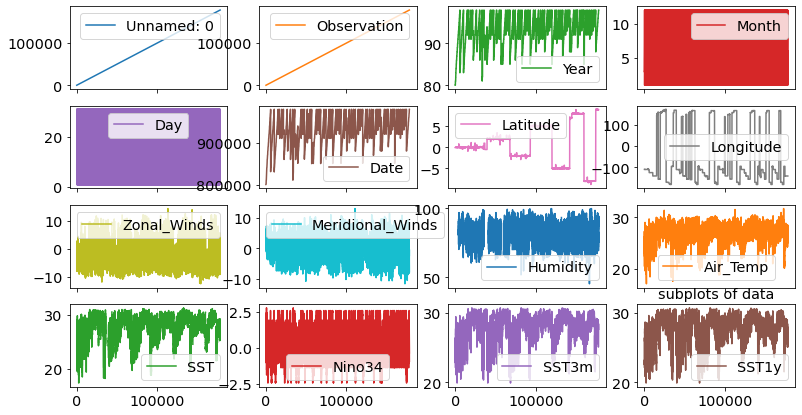

In [60]:
fig3 = plt.figure(figsize=(20,10))
df.plot(subplots=True, layout=(4,4))
plt.title("subplots of data")
#plt.savefig("2_subplot.pdf")

                  Unnamed: 0  Observation      Year     Month       Day  \
Unnamed: 0          1.000000     1.000000  0.297054 -0.009746 -0.000032   
Observation         1.000000     1.000000  0.297054 -0.009746 -0.000032   
Year                0.297054     0.297054  1.000000 -0.113791 -0.008831   
Month              -0.009746    -0.009746 -0.113791  1.000000  0.010957   
Day                -0.000032    -0.000032 -0.008831  0.010957  1.000000   
Date                0.297284     0.297284  0.999949 -0.103709 -0.008470   
Latitude           -0.035549    -0.035549 -0.015654  0.000357 -0.000491   
Longitude          -0.068291    -0.068291 -0.042441 -0.001037 -0.001042   
Zonal_Winds         0.006978     0.006978  0.030393  0.052563  0.006574   
Meridional_Winds   -0.149118    -0.149118 -0.199180  0.256753  0.005140   
Humidity           -0.006580    -0.006580 -0.015145 -0.134937 -0.001549   
Air_Temp            0.203581     0.203581  0.266370 -0.124025 -0.003721   
SST                 0.243

Text(0.5, 1.0, 'correlation between data')

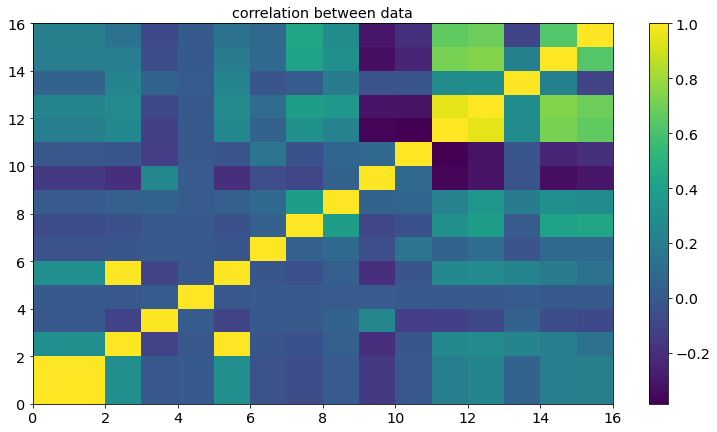

In [61]:
print(df.corr())
f4 = plt.figure()
plt.pcolormesh(df.corr())
cbar = plt.colorbar()
plt.title("correlation between data")

##  Notable features include that SST and Air Temp are highly correlated, so one of the two can be dropped. SST and SST 3m are also highly correlated, so we could use SST over AIr Temp. If we want to predict SST 3m, SST is probably the best feature to use. SST is also the most useful feature if we want to predict SST1y. SST 3m could be a useful feature but no data is available for it in the future.

## Let's also drop year, day, because they are not relevant, but keep month to allow for a seasonal cycle. Date and observation aren't useful, spatial information is likewise not useful if we assume we stay in one geographical location.

# Let's predict SST1y and drop data mentioned above.

In [62]:
### Use this to get the target data Y, drop nan values
df_no_nan = df.dropna(subset=['SST1y','SST'])

#### use this set of data for X features
df_no_nan_drop = df_no_nan.drop(['Unnamed: 0','Observation','Year', 'Day', 'Date', 'Latitude', 'SST3m', 'SST1y', 'Air_Temp'], axis=1)

## Check how remaining features are correlated

Text(0.5, 1.0, 'Correlation between remaining data')

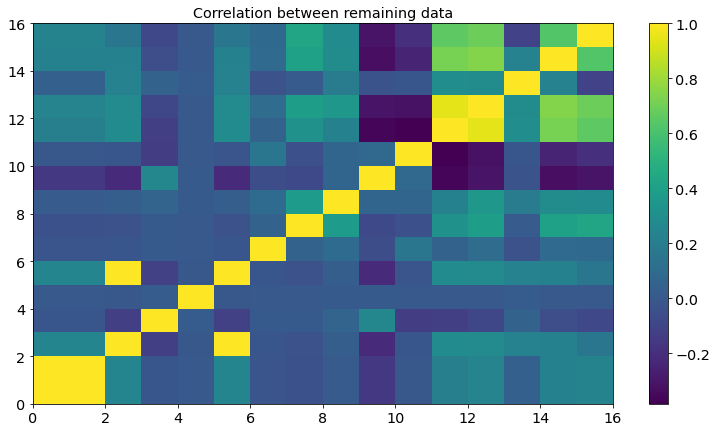

In [63]:
f5 = plt.figure()
plt.pcolormesh(df_no_nan.corr())
cbar = plt.colorbar()
plt.title("Correlation between remaining data")

## Fill out missing values.

In [64]:
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
X_features = imp.fit_transform(df_no_nan_drop)

## Assign target data

In [65]:
Y_target = df_no_nan['SST1y']

## Split the data into training and test sets. Note that the testing data comes from separate times than the training data to ensure a realistic prediction.

In [66]:
X_train, X_test, Y_train, Y_test = train_test_split(X_features,Y_target, test_size= 0.25)

##  Try random forest to see what quality of prediction we get.

In [67]:
rf = RandomForestRegressor(n_estimators=20, max_depth=10)
rf.fit(X_train, Y_train)
print("Training score:", rf.score(X_train, Y_train))
print("Testing score:", rf.score(X_test, Y_test))

Training score: 0.8447341479774282
Testing score: 0.8363327163064964


## We correctly predict the SST after one year with probability of 84 % on the training set and with 82% on the testing set. Let's see if we can do better.

In [68]:
#######validation and fine-tuning of the model #############
scores = cross_val_score(rf, X_train, Y_train, cv=10)
print("Cross-validation-scores:", scores )
print("Mean:", scores.mean())
print("Standard deviation:", scores.std())

Cross-validation-scores: [0.83693675 0.82973199 0.82862515 0.83564512 0.83806966 0.83545726
 0.8318361  0.83477038 0.83398604 0.83201337]
Mean: 0.8337071814316245
Standard deviation: 0.002923816551217358


## Can we improve the prediction with Random Forest by dropping additional data? Let's check the relative importance of each remaining feature.

Month 0.04017250164554759


Text(0.5, 1.0, 'Importance of features')

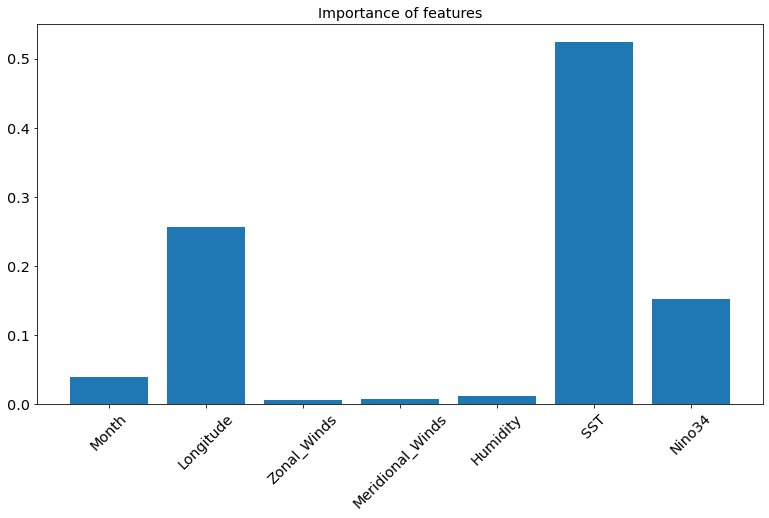

In [69]:
fig6 = plt.figure()
for i in range(np.shape(X)[1]):
    print(df_no_nan_drop.columns[i], rf.feature_importances_[i])
plt.bar(df_no_nan_drop.columns,rf.feature_importances_)
plt.xticks(rotation = 45)
plt.title('Importance of features')

## Seems that Zonal_Winds, Meridional_Winds, and Humidity are not necessary features. Make a new data loader without these features.

In [70]:
df_no_nan_drop

,Month,Longitude,Zonal_Winds,Meridional_Winds,Humidity,SST,Nino34
0,3,-109.46,-6.8,0.7,NaN,26.24,NaN
1,3,-109.46,-4.9,1.1,NaN,25.97,NaN
2,3,-109.46,-4.5,2.2,NaN,25.28,NaN
3,3,-109.46,-3.8,1.9,NaN,24.31,NaN
4,3,-109.46,-4.2,1.5,NaN,23.19,NaN
...,...,...,...,...,...,...,...
178075,6,-140.33,-5.1,-0.4,94.1,28.14,-0.583995
178076,6,-140.32,-4.3,-3.3,93.2,27.87,-0.411151
178077,6,-140.34,-6.1,-4.8,81.3,27.93,-0.452528
178078,6,-140.33,-4.9,-2.3,76.2,28.03,-0.415563


In [71]:
df_no_Hum_MorZwinds = df_no_nan_drop.drop(["Zonal_Winds","Meridional_Winds","Humidity"],axis=1)

imp = SimpleImputer(missing_values=np.nan, strategy='mean')

X_features_No_H_MorZwinds = imp.fit_transform(df_no_Hum_MorZwinds)

In [72]:
X_train_no_H_M_Z, X_test_no_H_M_Z, Y_train_no_H_M_Z, Y_test_no_H_M_Z = train_test_split(X_features_No_H_MorZwinds,Y_target, test_size= 0.25)




In [73]:
rf_no_H_M_Z = RandomForestRegressor(n_estimators=20, max_depth=10)
rf_no_H_M_Z.fit(X_train_no_H_M_Z, Y_train_no_H_M_Z)
print("Training score:", rf_no_H_M_Z.score(X_train_no_H_M_Z, Y_train_no_H_M_Z))
print("Testing score:", rf_no_H_M_Z.score(X_test_no_H_M_Z, Y_test_no_H_M_Z))

Training score: 0.8388714511469246
Testing score: 0.8309818483296636


In [75]:
#perform cross validation
#plt.bar(X_test_no_H_M_Z.columns,rf_no_H_M_Z.feature_importances_)
scores = cross_val_score(rf_no_H_M_Z, X_train_no_H_M_Z, Y_train_no_H_M_Z, cv=10)
print("Cross-validation-scores:", scores )
print("Mean:", scores.mean())
print("Standard deviation:", scores.std())

Cross-validation-scores: [0.82016831 0.82528838 0.83002775 0.82428116 0.83302262 0.83038298
 0.82936633 0.82997826 0.82839287 0.8271754 ]
Mean: 0.8278084070202223
Standard deviation: 0.003518276638785438


## Model Inference (predictions)

In [76]:
#Test the model with predicting 
training_pred = rf_no_H_M_Z.predict(X_train_no_H_M_Z)
test_pred = rf_no_H_M_Z.predict(X_test_no_H_M_Z)
print("RF Training MSE: %3.3f " %(mse(Y_train_no_H_M_Z,training_pred)))
print("RF Test MSE: %3.3f " %(mse(Y_test_no_H_M_Z,test_pred)))

RF Training MSE: 0.681 
RF Test MSE: 0.719 


In [77]:
#Correlation of SST observed and predicted
target = Y_test_no_H_M_Z.to_numpy()
print("Corelation: %3.3f" %(np.corrcoef(test_pred, target)[1][0]))

Corelation: 0.912


Text(0.5, 0, 'observed')

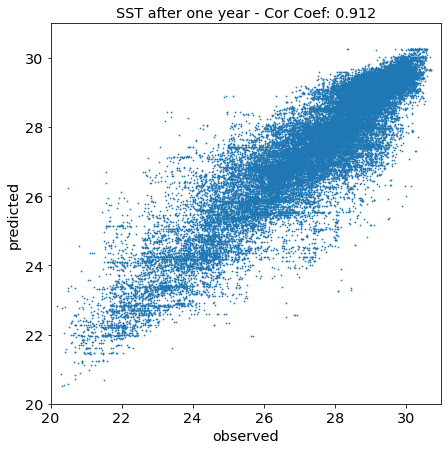

In [78]:
#scatterplot obs against predicted
obs = Y_test_no_H_M_Z.to_numpy()
plt.close()
fig7 = plt.figure(figsize=(7,7))
plt.scatter(obs,test_pred, s = 0.5)
plt.ylim(20,31)
plt.xlim(20,31)
plt.title("SST after one year - Cor Coef: %3.3f" %np.corrcoef(test_pred, obs)[1][0] )
plt.ylabel("predicted")
plt.xlabel("observed")
#plt.savefig("2scat.pdf")

4.  *  Predict  MJO  usingmjonino-80-89.ncdataset.   MJO  is  an  eastward  movingdisturbance  of  clouds,  rainfall,  winds,  and  pressure  that  traverses  the  planet  inthe tropics with a period between 30 to 90 days, on average.  MJO is tracked usingvarious indices and is best seen in wind anomalies at approximately 200hPa pressurelevel.  

In this exercise we will use OMI OLR MJO Index.Currently, the best NWP models can skillfully predict MJO about 3 weeks into thefuture,  while theoretical predictability limit seems to be about 7 weeks [2].  Yourgoal is to predict MJO 1 month into the future using OMI OLR MJO index.  

Theamplitude and phase values of this index at the time of the observation are storedinMJOampandMJOphvariables in the netcdf file.The values for the OMI index 30 days into the future are stored inMJOamp1mandMJOph1mvariables.   These  are  the  fields  to  predict.   You  can  choose  toforecast either amplitude or phase. 

Of course, if you feel ambitious, you can try topredict both, however we did not study multi-output regression.Compute MSE and correlation of your predictions with observedMJOamp1morMJOph1mvalues.  Plot time-series of predicted and observed values.

In [79]:
fname_mjo='mjonino-80-89.nc'

ds_mjo = xr.open_dataset(fname_mjo)

ds_mjo_200 = ds_mjo.sel(level=200).mean(dim='latitude')

df_mjo= ds_mjo_200.to_dataframe().to_csv('df_mjo.csv')

In [80]:
ds_mjo_200

<xarray.Dataset>
Dimensions:    (longitude: 72, time: 3653)
Coordinates:
  * longitude  (longitude) float32 -180.0 -175.0 -170.0 ... 165.0 170.0 175.0
    level      int32 200
  * time       (time) datetime64[ns] 1980-01-01T12:00:00 ... 1989-12-31T12:00:00
Data variables: (12/14)
    z          (time, longitude) float32 1.222e+05 1.221e+05 ... 1.219e+05
    t          (time, longitude) float32 221.6 221.6 221.6 ... 220.3 220.2 220.4
    w          (time, longitude) float32 -0.04768 0.001843 ... -0.01197 -0.05058
    r          (time, longitude) float32 67.04 71.01 78.29 ... 28.5 37.64 39.35
    u          (time, longitude) float32 5.262 5.296 4.05 ... -2.875 -1.01
    v          (time, longitude) float32 2.665 4.63 4.896 ... 0.5944 1.752
    ...         ...
    nino34     (time) float32 nan nan nan nan ... -0.03152 0.03259 -0.08057
    nino343m   (time) float32 nan nan nan nan ... -0.03537 0.01657 0.1518
    MJOamp     (time) float64 0.3815 0.469 0.5494 0.6191 ... 1.98 1.904 1.82
    MJOph      (time) float64 1.464 1.432 1.395 1.361 ... 0.03008 0.1583 0.2917
    MJOamp1m   (time) float64 0.2467 0.4266 0.6225 0.8159 ... 2.603 2.521 2.473
    MJOph1m    (time) float64 1.464 1.432 1.395 1.361 ... 0.03008 0.1583 0.2917

In [81]:
df_mjo = pd.read_csv ('df_mjo.csv')

df_mjo['time']= pd.to_datetime(df_mjo['time'])

df_mjo['day'] = df_mjo.time.dt.day

In [82]:
df_mjo

,longitude,time,level,z,t,w,r,u,v,sst,nino341y,nino34,nino343m,MJOamp,MJOph,MJOamp1m,MJOph1m,day
0,-180.0,1980-01-01 12:00:00,200,122201.900,221.58696,-0.047678,67.040184,5.262250,2.665327,301.89430,NaN,NaN,NaN,0.381505,1.463963,0.246723,1.463963,1
1,-180.0,1980-01-02 12:00:00,200,122129.890,222.23740,-0.028131,59.441210,6.450736,4.906308,301.89386,NaN,NaN,NaN,0.469024,1.432107,0.426582,1.432107,2
2,-180.0,1980-01-03 12:00:00,200,122177.360,222.51762,-0.069200,67.472466,6.774890,1.715381,301.89044,NaN,NaN,NaN,0.549352,1.395051,0.622500,1.395051,3
3,-180.0,1980-01-04 12:00:00,200,122252.600,221.71667,-0.049770,69.223900,7.479925,0.224877,301.88956,NaN,NaN,NaN,0.619099,1.360809,0.815850,1.360809,4
4,-180.0,1980-01-05 12:00:00,200,122200.820,221.99900,-0.018076,71.699130,5.928154,-1.149545,301.88727,NaN,NaN,NaN,0.677888,1.331367,0.996280,1.331367,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
263011,175.0,1989-12-27 12:00:00,200,122023.360,220.67732,-0.044360,45.391216,-0.359504,-2.706798,302.09726,0.335425,-0.070803,-0.230692,2.081389,-0.214115,2.802088,-0.214115,27
263012,175.0,1989-12-28 12:00:00,200,122047.640,220.38414,-0.064213,62.769745,0.269123,1.735696,302.10605,0.396536,-0.046135,-0.094487,2.039775,-0.093736,2.702527,-0.093736,28
263013,175.0,1989-12-29 12:00:00,200,121839.695,220.32979,-0.001921,45.294746,4.205508,-1.688750,302.11154,0.519831,-0.031518,-0.035371,1.979506,0.030083,2.602801,0.030083,29
263014,175.0,1989-12-30 12:00:00,200,121691.086,220.09697,0.008419,42.784650,2.623869,-1.699972,302.11844,0.439851,0.032586,0.016567,1.904485,0.158309,2.520597,0.158309,30


## Check correlation between features to determine which to keep or drop.

              longitude  level         z         t         w         r  \
longitude  1.000000e+00    NaN  0.436696  0.277070 -0.216723  0.315313   
level               NaN    NaN       NaN       NaN       NaN       NaN   
z          4.366961e-01    NaN  1.000000  0.589600 -0.245552  0.181758   
t          2.770703e-01    NaN  0.589600  1.000000 -0.195247 -0.101323   
w         -2.167228e-01    NaN -0.245552 -0.195247  1.000000 -0.370118   
r          3.153129e-01    NaN  0.181758 -0.101323 -0.370118  1.000000   
u         -5.027331e-01    NaN -0.373484 -0.168015  0.154281 -0.365703   
v         -8.370293e-02    NaN  0.012180  0.023563  0.019624 -0.098706   
sst        3.919939e-01    NaN  0.450014  0.430802 -0.262776  0.251298   
nino341y   5.930789e-16    NaN -0.124644 -0.239972 -0.001792  0.064491   
nino34    -5.770612e-16    NaN  0.325232  0.121283 -0.011160  0.019840   
nino343m  -1.387880e-15    NaN  0.151383 -0.059748 -0.008743  0.027637   
MJOamp     1.395761e-14    NaN  0.0112

Text(0.5, 1.0, 'Correlation between data')

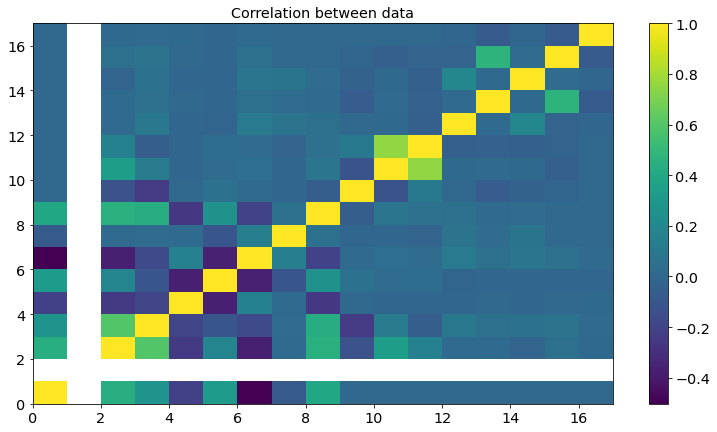

In [83]:
print(df_mjo.corr())
f_mjo = plt.figure()
plt.pcolormesh(df_mjo.corr())
cbar = plt.colorbar()
plt.title("Correlation between data")

## Let's try to predict the phase 1 month into the future, since it is highly correlated with it's phase a month before.

In [84]:
## drop nan values 

df_mjo_no_nan = df_mjo.dropna(subset=['nino341y','nino34','nino343m','MJOamp1m','MJOph1m','day','time'])

## drop features that are negatively correlated, or features containing future data

#### use this set of data for X features

df_mjo_no_nan_drop = df_mjo_no_nan.drop(['r','v','sst','nino341y','nino34','nino343m','MJOamp','MJOamp1m','MJOph1m','level','time'], axis=1)



In [85]:
print(len(ds_mjo['MJOph1m']))
print(len(df_mjo['MJOph1m']))
print(len(df_mjo_no_nan['MJOph1m']))

3653
263016
219168


In [86]:
df_mjo_no_nan_drop

,longitude,z,t,w,u,MJOph,day
609,-180.0,121587.250,218.34683,0.008592,-1.027724,-0.128417,1
610,-180.0,121527.110,218.27724,-0.021852,1.833396,-0.016371,2
611,-180.0,121469.390,218.65321,-0.026131,0.999163,0.090581,3
612,-180.0,121623.670,218.84303,-0.043556,2.084847,0.190861,4
613,-180.0,121684.336,219.06131,-0.015044,0.523352,0.284993,5
...,...,...,...,...,...,...,...
263011,175.0,122023.360,220.67732,-0.044360,-0.359504,-0.214115,27
263012,175.0,122047.640,220.38414,-0.064213,0.269123,-0.093736,28
263013,175.0,121839.695,220.32979,-0.001921,4.205508,0.030083,29
263014,175.0,121691.086,220.09697,0.008419,2.623869,0.158309,30


 ## Fill out remaining missing values.

In [87]:
imp_mjo = SimpleImputer(missing_values=np.nan, strategy='mean')

X_features_mjo = imp_mjo.fit_transform(df_mjo_no_nan_drop)

## Assign mjo phase to variable, this is what we will predict.

In [88]:
Y_target_mjo = df_mjo_no_nan['MJOph1m']

## Split data into training and testing

In [89]:
X_train_mjo, X_test_mjo, Y_train_mjo, Y_test_mjo = train_test_split(X_features_mjo,Y_target_mjo, test_size= 0.25)

In [90]:
rf_mjo = RandomForestRegressor(n_estimators=20, max_depth=10)
rf_mjo.fit(X_train_mjo, Y_train_mjo)
print("Training score:", rf_mjo.score(X_train_mjo, Y_train_mjo))
print("Testing score:", rf_mjo.score(X_test_mjo, Y_test_mjo))

Training score: 0.5284721240703802
Testing score: 0.516430786943485


## Check importance of remaining features.

longitude 0.008203209646952507
z 0.024142196453720968
t 0.021074919375030803
w 0.00098170549640993
u 0.027222432306188114
MJOph 0.7689498187647821
day 0.14942571795691562


Text(0.5, 1.0, 'Importance of features')

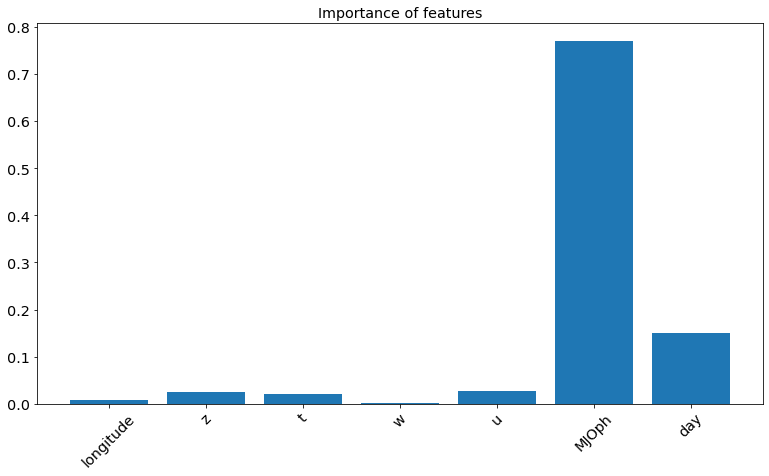

In [91]:
fig_mjo = plt.figure()
for i in range(np.shape(X_features_mjo)[1]):
    print(df_mjo_no_nan_drop.columns[i], rf_mjo.feature_importances_[i])
plt.bar(df_mjo_no_nan_drop.columns,rf_mjo.feature_importances_)
plt.xticks(rotation = 45)
plt.title('Importance of features')

## Let's drop zonal, meridional,vertical wind, temperature

In [92]:
df_no_wind_drop = df_mjo_no_nan_drop.drop(['u','z','w','t'],axis=1)

imp_mjo = SimpleImputer(missing_values=np.nan, strategy='mean')

X_features_mjo_no_wind = imp_mjo.fit_transform(df_no_wind_drop)

In [93]:
X_train_mjo_no_win, X_test_mjo_no_win, Y_train_mjo_no_win, Y_test_mjo_no_win = train_test_split(X_features_mjo_no_wind,Y_target_mjo, test_size= 0.25)


In [94]:
rf_mjo_no_win = RandomForestRegressor(n_estimators=20, max_depth=10)
rf_mjo_no_win.fit(X_train_mjo_no_win, Y_train_mjo_no_win)
print("Training score:", rf_mjo_no_win.score(X_train_mjo_no_win, Y_train_mjo_no_win))
print("Testing score:", rf_mjo_no_win.score(X_test_mjo_no_win, Y_test_mjo_no_win))

Training score: 0.5500238979289842
Testing score: 0.5481082724566027


## The training and testing score are marginally better without wind information, and the model takes less time to train.

In [95]:
#Test the model with predicting 
training_pred_mjo = rf_mjo_no_win.predict(X_train_mjo_no_win)
test_pred_mjo = rf_mjo_no_win.predict(X_test_mjo_no_win)
print("RF_MJO_NO_WIND Training MSE: %3.3f " %(mse(Y_train_mjo_no_win,training_pred_mjo)))
print("RF_MJO_NO_WIND Test MSE: %3.3f " %(mse(Y_test_mjo_no_win,test_pred_mjo)))

RF_MJO_NO_WIND Training MSE: 1.435 
RF_MJO_NO_WIND Test MSE: 1.442 


Text(0, 0.5, 'Phase')

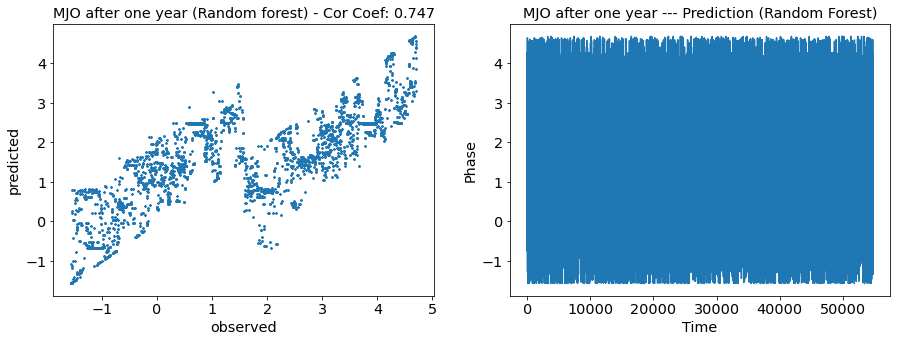

In [153]:
fig,ax = plt.subplots(1,2,figsize=(15,5))
ax = ax.ravel()
obs_mjo = Y_test_mjo_no_win.to_numpy()

ax[0].scatter(obs_mjo,test_pred_mjo, s = 0.5)
#ax[0].set_ylim(20,31)
#ax[0].set_xlim(20,31)
ax[0].set_title("MJO after one year (Random forest) - Cor Coef: %3.3f" %np.corrcoef(test_pred_mjo, obs_mjo)[1][0] )
ax[0].set_ylabel("predicted")
ax[0].set_xlabel("observed")

ax[1].plot(test_pred_mjo)
ax[1].set_title("MJO after one year --- Prediction (Random Forest)")
ax[1].set_xlabel("Time")
ax[1].set_ylabel("Phase")
#ax[1].plot(obs_mjo)

## Let's try a deep learning approach

Text(0.5, 1.0, ' MJO Phase 1 month into future')

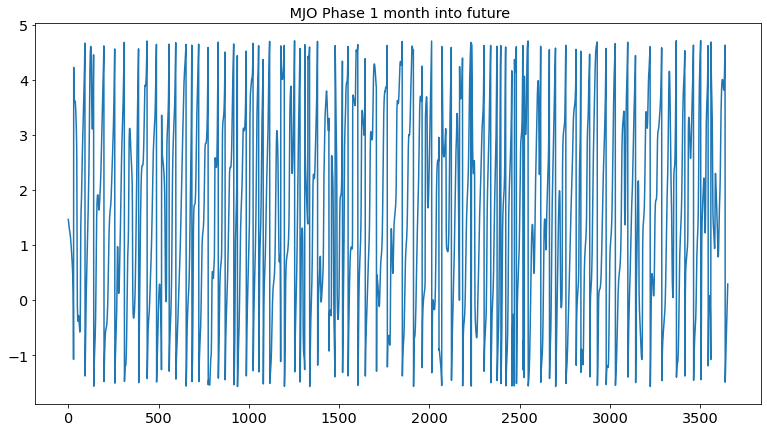

In [150]:
phase = ds_mjo['MJOph1m']
plt.plot(phase)
plt.title(' MJO Phase 1 month')

In [98]:
model_deep = keras.models.Sequential([keras.layers.InputLayer(input_shape=X_train_mjo.shape[1:]),
                                 keras.layers.BatchNormalization(),
                                 keras.layers.Dense(100, activation="relu" ),
                                      #keras.layers.Dropout(rate=0.5),
                                 keras.layers.BatchNormalization(),
                                 keras.layers.Dense(100, activation="relu"),
                                 keras.layers.BatchNormalization(),
                                      keras.layers.Dropout(rate=0.2),
                                 keras.layers.Dense(1, activation="linear")])

In [99]:
model_deep.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 7)                 28        
_________________________________________________________________
dense_6 (Dense)              (None, 100)               800       
_________________________________________________________________
batch_normalization_1 (Batch (None, 100)               400       
_________________________________________________________________
dense_7 (Dense)              (None, 100)               10100     
_________________________________________________________________
batch_normalization_2 (Batch (None, 100)               400       
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 1

In [100]:
epochs=15
lr = tf.keras.optimizers.schedules.PolynomialDecay(1e-3, epochs, 1e-4)
opt_deep = tf.keras.optimizers.Adam(lr)
model_deep.compile(loss="mse", optimizer=opt_deep, metrics=["mae"])

In [101]:
es = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.001,patience=5, restore_best_weights=True)

Train on 147938 samples, validate on 16438 samples
Epoch 1/15
147938/147938 [==============================] - 33s 220us/sample - loss: 2.6000 - mae: 1.4701 - val_loss: 2.2326 - val_mae: 1.4383
Epoch 2/15
147938/147938 [==============================] - 38s 256us/sample - loss: 2.4504 - mae: 1.4536 - val_loss: 2.2131 - val_mae: 1.4313
Epoch 3/15
147938/147938 [==============================] - 39s 261us/sample - loss: 2.3794 - mae: 1.4448 - val_loss: 2.1986 - val_mae: 1.4210
Epoch 4/15
147938/147938 [==============================] - 39s 265us/sample - loss: 2.3405 - mae: 1.4391 - val_loss: 2.1850 - val_mae: 1.4170
Epoch 5/15
147938/147938 [==============================] - 40s 273us/sample - loss: 2.3111 - mae: 1.4305 - val_loss: 2.1715 - val_mae: 1.4067
Epoch 6/15
147938/147938 [==============================] - 41s 275us/sample - loss: 2.2936 - mae: 1.4243 - val_loss: 2.1578 - val_mae: 1.4003
Epoch 7/15
147938/147938 [==============================] - 40s 270us/sample - loss: 2.2804

<AxesSubplot:>

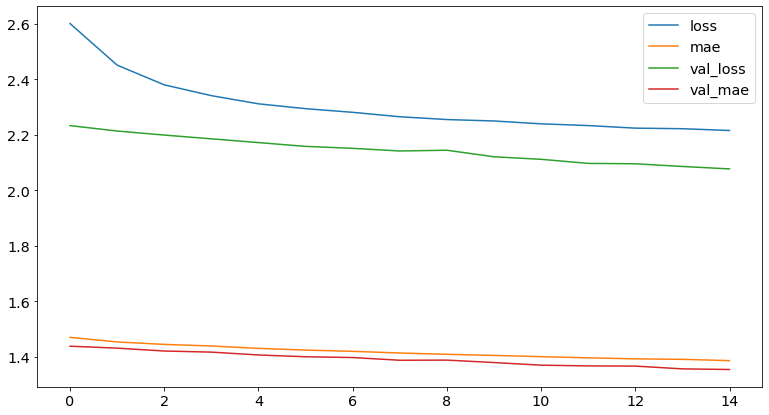

In [103]:
history_deep = model_deep.fit(tf.cast(X_train_mjo,dtype=tf.float32),tf.cast(Y_train_mjo,dtype=tf.float32), epochs=epochs, validation_split=0.1,callbacks=[es])
pd.DataFrame(history_deep.history).plot()

Deep learning R2: 0.353, MSE: 2.066 


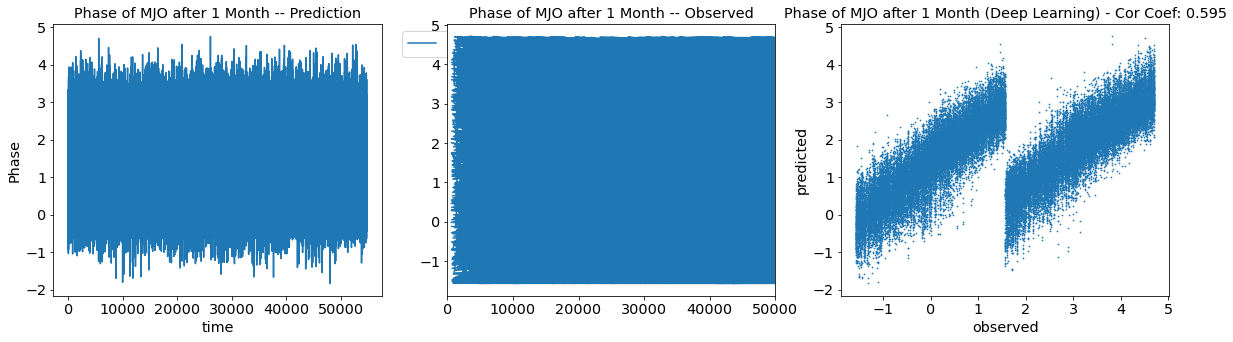

In [148]:
fig,ax = plt.subplots(1,3,figsize=(20,5))

ax=ax.ravel()

pred_deep = model_deep.predict(tf.cast(X_test_mjo,dtype=tf.float32))

obs_mjo_deep = Y_test_mjo.to_numpy()

print("Deep learning R2: %3.3f, MSE: %3.3f " %(r2_score(Y_test_mjo, pred_deep), mse(Y_test_mjo, pred_deep)))

Y_test_mjo.plot(ax=ax[1],label = "time series (test-data)")

ax[1].set_xlim(0,50000)

ax[0].plot(pred_deep, label = "Deep learning: MSE (test-data) = %3.2f" %(mse(Y_test_mjo,pred_deep)))

ax[0].set_title("Phase of MJO after 1 Month -- Prediction")

ax[1].set_title("Phase of MJO after 1 Month -- Observed")

ax[2].scatter(obs_mjo_deep,pred_deep, s = 0.5)
ax[2].set_title("Phase of MJO after 1 Month (Deep Learning) - Cor Coef: %3.3f" %np.corrcoef(pred_deep.flatten(), obs_mjo_deep)[1][0] )
ax[2].set_ylabel("predicted")
ax[2].set_xlabel("observed")


ax[0].set_xlabel("time")
ax[0].set_ylabel("Phase")
ax[0].legend(bbox_to_anchor=(1.04,1), loc="upper left")
#plt.title('Non-linear fitting with DNN')

## Random forest offers the best prediction here, 0.74 correlation on prediction for test data and (RF_MJO_NO_WIND ) Test MSE: 1.442. The deep learning correlation of 0.595 is consistent with the correlation found in literature for a one month prediction of MJO phase (Silini et. al 2021).

3.  * Predict ENSO usingmjonino-80-89.ncdataset.  ENSO is an irregular periodicvariation  in  winds  and  sea  surface  temperatures  over  the  tropical  eastern  PacificOcean, affecting the climate of much of the tropics and subtropics.  ENSO is trackedusing various climate indices.  In this exercise we will use Nino 3.4 index, which isbased on Sea Surface Temperature (SST) anomaly in the box 5N/-5S/120W/170W.

Since  ENSO  might  significantly  impact  agriculture  in  the  equatorial  Pacific,  it  is desirable  to  predict  it  at  least  1  year  in  advance,  which  is  however  difficult  formodern  climate  models.   In  the  lab  you  need  to  predict  Nino  3.4  in  the  futurebased on current values of the fields.  The file containsnino341yandnino343m,which are the future values of the index from, respectively, 1 year and 3month. 

You22
can choose which of these two fields you want to predict, which would correspond,respectively, to 1 year and 3 month forecast length.Compute MSE and correlation of your predictions with observed values.  Plot time-series of predicted and observed values

In [105]:
ds_nino = xr.open_dataset(fname_mjo)

ds_nino_200 = ds_mjo.mean(dim=['latitude','level'])

df_nino= ds_nino_200.to_dataframe().to_csv('df_nino.csv')

In [106]:
ds_nino

<xarray.Dataset>
Dimensions:    (longitude: 72, latitude: 7, level: 4, time: 3653)
Coordinates:
  * longitude  (longitude) float32 -180.0 -175.0 -170.0 ... 165.0 170.0 175.0
  * latitude   (latitude) float32 15.0 10.0 5.0 0.0 -5.0 -10.0 -15.0
  * level      (level) int32 200 500 850 1000
  * time       (time) datetime64[ns] 1980-01-01T12:00:00 ... 1989-12-31T12:00:00
Data variables: (12/14)
    z          (time, level, latitude, longitude) float32 ...
    t          (time, level, latitude, longitude) float32 ...
    w          (time, level, latitude, longitude) float32 ...
    r          (time, level, latitude, longitude) float32 ...
    u          (time, level, latitude, longitude) float32 ...
    v          (time, level, latitude, longitude) float32 ...
    ...         ...
    nino34     (time) float32 ...
    nino343m   (time) float32 ...
    MJOamp     (time) float64 ...
    MJOph      (time) float64 ...
    MJOamp1m   (time) float64 ...
    MJOph1m    (time) float64 ...
Attributes:
    Conventions:  CF-1.6
    history:      2021-06-20 23:58:00 GMT by grib_to_netcdf-2.21.0: grib_to_n...

In [107]:
df_nino = pd.read_csv ('df_nino.csv')

df_nino['time']= pd.to_datetime(df_nino['time'])

df_nino['day'] = df_nino.time.dt.day

              longitude         z         t         w         r         u  \
longitude  1.000000e+00  0.213655  0.450734 -0.179930  0.207223 -0.255008   
z          2.136554e-01  1.000000  0.153373 -0.017489  0.031569 -0.333930   
t          4.507339e-01  0.153373  1.000000 -0.352023 -0.159080 -0.091906   
w         -1.799305e-01 -0.017489 -0.352023  1.000000 -0.168867  0.081376   
r          2.072226e-01  0.031569 -0.159080 -0.168867  1.000000 -0.138462   
u         -2.550079e-01 -0.333930 -0.091906  0.081376 -0.138462  1.000000   
v          4.219014e-03  0.023941 -0.031086  0.044578 -0.121548 -0.022093   
sst        3.919939e-01  0.084939  0.604353 -0.238784  0.316614 -0.187701   
nino341y   5.930789e-16 -0.078299 -0.107363 -0.001369  0.026514  0.030730   
nino34    -5.770612e-16  0.292362  0.145184 -0.014278  0.018362  0.077008   
nino343m  -1.387880e-15  0.162286  0.052538 -0.009401  0.025992  0.067483   
MJOamp     1.395761e-14 -0.054045  0.059447 -0.006101 -0.012540  0.114397   

Text(0.5, 1.0, 'Correlation between data')

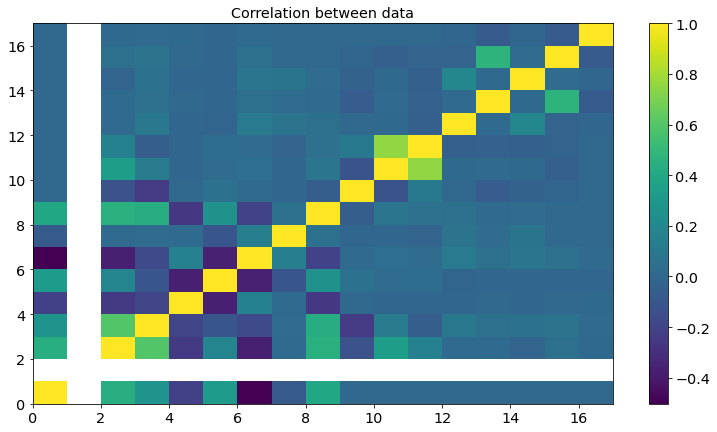

In [108]:
print(df_nino.corr())
f_nino = plt.figure()
plt.pcolormesh(df_mjo.corr())
cbar = plt.colorbar()
plt.title("Correlation between data")

In [109]:
## drop nan values 

df_nino_no_nan = df_mjo.dropna(subset=['nino341y','nino34','nino343m','MJOamp1m','MJOph1m','day','time'])

## drop features that are negatively correlated, or features containing future data

#### use this set of data for X features

df_nino_no_nan_drop = df_nino_no_nan.drop(['r','v','nino341y','nino343m','MJOamp','MJOamp1m','MJOph1m','level','time'], axis=1)


In [110]:
imp_nino = SimpleImputer(missing_values=np.nan, strategy='mean')

X_features_nino = imp_mjo.fit_transform(df_nino_no_nan_drop)

## Let's predict Nino 3.4 1y using RF

In [111]:
Y_target_nino = df_nino_no_nan['nino341y']

In [112]:
X_train_nino, X_test_nino, Y_train_nino, Y_test_nino = train_test_split(X_features_nino,Y_target_nino, test_size= 0.25)

In [113]:
rf_nino = RandomForestRegressor(n_estimators=20, max_depth=10)
rf_nino.fit(X_train_nino, Y_train_nino)
print("Training score:", rf_nino.score(X_train_nino, Y_train_nino))
print("Testing score:", rf_nino.score(X_test_nino, Y_test_nino))

Training score: 0.595707106558695
Testing score: 0.5894746121834502


longitude 0.03284926229449749
z 0.030131463530234274
t 0.16746359109860326
w 0.0007244787983930007
u 0.01372133289527565
sst 0.01315948105620755
nino34 0.523858347741167
MJOph 0.12085826418862554
day 0.09723377839699619


Text(0.5, 1.0, 'Importance of features')

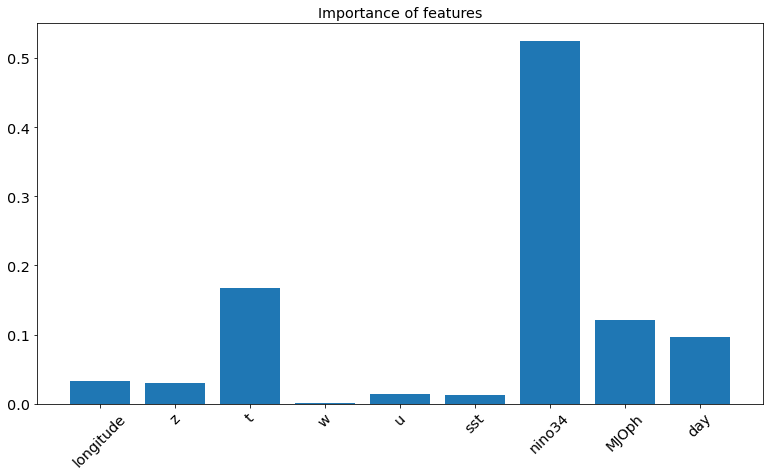

In [114]:
fig_ninob = plt.figure()
for i in range(np.shape(X_features_nino)[1]):
    print(df_nino_no_nan_drop.columns[i], rf_nino.feature_importances_[i])
plt.bar(df_nino_no_nan_drop.columns,rf_nino.feature_importances_)
plt.xticks(rotation = 45)
plt.title('Importance of features')

In [116]:
#Test the model with predicting 
training_pred_nino = rf_nino.predict(X_train_nino)
test_pred_nino = rf_nino.predict(X_test_nino)
print("RF_Nino Training MSE: %3.3f " %(mse(Y_train_nino,training_pred_nino)))
print("RF_Nino Test MSE: %3.3f " %(mse(Y_test_nino,test_pred_nino)))

RF_Nino Training MSE: 0.406 
RF_Nino Test MSE: 0.413 


Text(0.5, 1.0, 'Nino 3.4 Observed time-series')

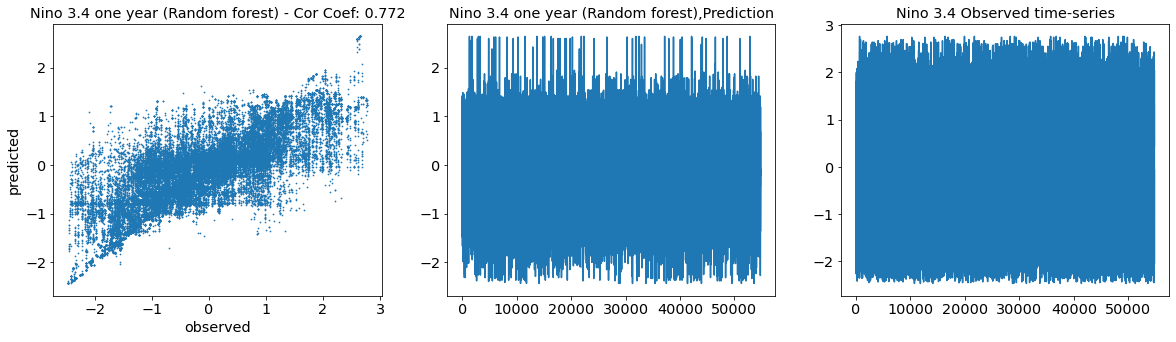

In [144]:
fig,ax = plt.subplots(1,3,figsize=(20,5))
ax = ax.ravel()
obs_nino = Y_test_nino.to_numpy()

ax[0].scatter(obs_nino,test_pred_nino, s = 0.5)
#ax[0].set_ylim(20,31)
#ax[0].set_xlim(20,31)
ax[0].set_title("Nino 3.4 one year (Random forest) - Cor Coef: %3.3f" %np.corrcoef(test_pred_nino, obs_nino)[1][0])# %mse(Y_test_nino,test_pred_nino))
ax[0].set_ylabel("predicted")
ax[0].set_xlabel("observed")

ax[1].plot(test_pred_nino)
ax[1].set_title("Nino 3.4 one year (Random forest),Prediction")
ax[2].plot(obs_nino)
ax[2].set_title("Nino 3.4 Observed time-series")
#ax[1].plot(obs_mjo)

## Now try deep learning

In [118]:
model_deep_nino = keras.models.Sequential([keras.layers.InputLayer(input_shape=X_train_nino.shape[1:]),
                                 keras.layers.BatchNormalization(),
                                 keras.layers.Dense(100, activation="relu" ),
                                      #keras.layers.Dropout(rate=0.5),
                                 keras.layers.BatchNormalization(),
                                 keras.layers.Dense(100, activation="relu"),
                                 keras.layers.BatchNormalization(),
                                      keras.layers.Dropout(rate=0.2),
                                 keras.layers.Dense(1, activation="linear")])

In [119]:
epochs=15
lr = tf.keras.optimizers.schedules.PolynomialDecay(1e-3, epochs, 1e-4)
opt_deep = tf.keras.optimizers.Adam(lr)
model_deep_nino.compile(loss="mse", optimizer=opt_deep, metrics=["mae"])

In [120]:
es = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.001,patience=5, restore_best_weights=True)

Train on 147938 samples, validate on 16438 samples
Epoch 1/15
147938/147938 [==============================] - 38s 255us/sample - loss: 1.0278 - mae: 0.8113 - val_loss: 0.6677 - val_mae: 0.6598
Epoch 2/15
147938/147938 [==============================] - 36s 245us/sample - loss: 0.7653 - mae: 0.7025 - val_loss: 0.6277 - val_mae: 0.6345
Epoch 3/15
147938/147938 [==============================] - 36s 246us/sample - loss: 0.7009 - mae: 0.6683 - val_loss: 0.6091 - val_mae: 0.6200
Epoch 4/15
147938/147938 [==============================] - 40s 271us/sample - loss: 0.6747 - mae: 0.6533 - val_loss: 0.5942 - val_mae: 0.6102
Epoch 5/15
147938/147938 [==============================] - 37s 252us/sample - loss: 0.6609 - mae: 0.6448 - val_loss: 0.5822 - val_mae: 0.6040
Epoch 6/15
147938/147938 [==============================] - 36s 246us/sample - loss: 0.6497 - mae: 0.6383 - val_loss: 0.5724 - val_mae: 0.5973
Epoch 7/15
147938/147938 [==============================] - 35s 236us/sample - loss: 0.6418

<AxesSubplot:>

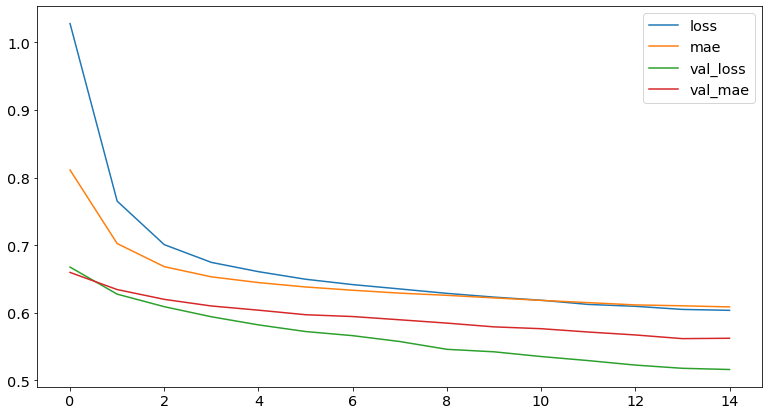

In [121]:

history_deep_nino = model_deep_nino.fit(tf.cast(X_train_nino,dtype=tf.float32),tf.cast(Y_train_nino,dtype=tf.float32), epochs=epochs, validation_split=0.1,callbacks=[es])
pd.DataFrame(history_deep_nino.history).plot()

Deep learning R2: 0.496, MSE on test data: 0.507 


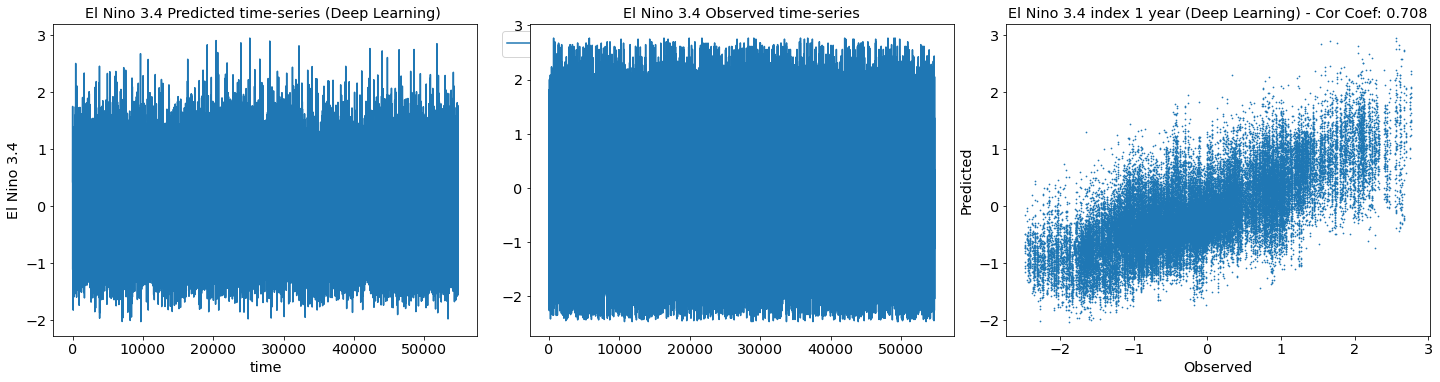

In [146]:
fig,ax = plt.subplots(1,3,figsize=(20,5))

fig.tight_layout() 

ax=ax.ravel()

pred_deep_nino = model_deep_nino.predict(tf.cast(X_test_nino,dtype=tf.float32))

obs_nino_deep = Y_test_nino.to_numpy()

print("Deep learning R2: %3.3f, MSE on test data: %3.3f " %(r2_score(Y_test_nino, pred_deep_nino), mse(Y_test_nino, pred_deep_nino)))

ax[1].plot(obs_nino_deep)


ax[0].plot(pred_deep_nino, label = "Deep learning: MSE (test-data) = %3.2f" %(mse(Y_test_nino,pred_deep_nino)))

ax[2].scatter(obs_nino_deep,pred_deep_nino, s = 0.5)
ax[2].set_title("El Nino 3.4 index 1 year (Deep Learning) - Cor Coef: %3.3f" %np.corrcoef(pred_deep_nino.flatten(), obs_nino_deep)[1][0] )
ax[2].set_ylabel("Predicted")
ax[2].set_xlabel("Observed")

ax[1].set_title("El Nino 3.4 Observed time-series" )


ax[0].set_xlabel("time")
ax[0].set_title("El Nino 3.4 Predicted time-series (Deep Learning) ")
ax[0].set_ylabel("El Nino 3.4")
ax[0].legend(bbox_to_anchor=(1.04,1), loc="upper left")
#plt.title('Non-linear fitting with DNN')

## Based on MSE and Pearson Correlation , random forest is best with MSE = 0.413, R2 = 0.77. The deep learning correlation score (0.70)  also seems to be consistent with the 1 year predictions made in Ham, Y.-G., Kim, J.-H., & Luo, J.-J. 2019, Nature, 573, 568. So this might be more realistic.